# Quantinuum Hybrid Compute via pytket

This notebook contains an example of how to create and run hybrid classical-quantum workflows within the Quantinuum stack via `pytket`.

**Note:** This notebook uses existing Wasm examples provided in this folder's subdirectories. To create and run your own Wasm functions, you'll need to set up an environment on your machine to support this workflow. Instructions for how to do this are given in this folder's README.

This is a simple example made of how you can process measurements, using classical logic via Wasm, to implement a quantum loop, or a repeat-until-success (RUS) style circuit, also called an exit-on-failure circuit.

## Set up `QuantinuumBackend` and load in WASM functions


Note the `wasm` module imported from `pytket` as well as several several conditional operators that are options. More information on the conditional operations available can be found in the user manual at [Classical and Conditional Operations](https://tket.quantinuum.com/api-docs/classical.html).


In [1]:
from pytket.extensions.quantinuum import QuantinuumBackend, QuantinuumAPIOffline

machine = "H1-1E"
api_offline = QuantinuumAPIOffline()
backend = QuantinuumBackend(device_name=machine)  # , api_handler=api_offline)
backend.login()

Enter your Quantinuum email:  callum.macpherson@quantinuum.com
Enter your Quantinuum password:  ········


Set up the RUS circuit. This involves 2 steps:
1. Set up Wasm File handler. This checks the Wasm file and can list the available functions within the file.
2. Set up the pytket circuit, which calls the Wasm file handler.

In [2]:
import pathlib
from pytket import wasm

rus_dir = pathlib.Path().cwd().joinpath("RUS")
wasm_file = rus_dir.joinpath("rus_wasm.wasm")
wfh = wasm.WasmFileHandler(wasm_file)

print(repr(wfh))

Functions in wasm file with the uid f5265965c9f207c02e626e3fd48183b545f74877a27c62c3fcc2cc68bee5a36a:
function 'init' with 0 i32 parameter(s) and 0 i32 return value(s)
function 'add_count' with 2 i32 parameter(s) and 1 i32 return value(s)



## Build the repeat-until-success circuit with a WASM call

In [3]:
from pytket.circuit import Circuit, Qubit
from pytket.circuit.logic_exp import reg_lt


def build_rus_circuit(n_repetitions: int, cond_execute: int) -> Circuit:
    """
    n_repetitions (int): number of attempts
    cond_execute: condition to execute, i.e. run this until a total of cond_execute |1> measurements is achieved.

    """
    # Create circuit with two qubits
    circuit = Circuit(2, name=f"RUS_limit {n_repetitions} cond {cond_execute}")

    # Add classical registers
    creg0 = circuit.add_c_register("creg0", 1)
    creg1 = circuit.add_c_register("creg1", 1)
    cond = circuit.add_c_register("cond", 32)
    count = circuit.add_c_register("count", 32)

    # Set cond to 0
    circuit.add_c_setreg(0, cond)

    # Loops
    for loop_iter in range(1, n_repetitions + 1):

        circuit.H(0, condition=reg_lt(cond, cond_execute))
        circuit.CX(0, 1, condition=reg_lt(cond, cond_execute))
        circuit.Measure(Qubit(1), creg1[0], condition=reg_lt(cond, cond_execute))

        # Add wasm call with the parameters creg1 and count, writing the result to cond
        # The function "add_count" is used from the Wasm file
        circuit.add_wasm_to_reg(
            "add_count",
            wfh,
            [creg1, count],
            [cond],
            condition=reg_lt(cond, cond_execute),
        )

        circuit.add_c_setreg(loop_iter, count, condition=reg_lt(cond, cond_execute))
        circuit.Reset(0, condition=reg_lt(cond, cond_execute))

    circuit.Measure(Qubit(0), creg0[0])
    circuit.Measure(Qubit(1), creg1[0])

    return circuit

In [4]:
from pytket.circuit.display import render_circuit_jupyter

circuit = build_rus_circuit(5, 3)

render_circuit_jupyter(circuit)

## Circuit Compilation

`pytket` includes many features for optimizing circuits. This includes reducing the number of gates where possible and resynthesizing circuits for a quantum computer's native gate set. See the `pytket` [user manual](https://tket.quantinuum.com/user-manual/) for more information on all the options that are available.

Here the circuit is compiled with `get_compiled_circuit`, which includes optimizing the gates and resynthesizing the circuit to Quantinuum's native gate set. The `optimisation_level` sets the level of optimisation to perform during compilation, check `pytket-quantinuum` documentation for more information, specifically the [default compilation](https://tket.quantinuum.com/extensions/pytket-quantinuum/#default-compilation) section.

In [5]:
compiled_circuit = backend.get_compiled_circuit(circuit, optimisation_level=0)

render_circuit_jupyter(compiled_circuit)

## Check Circuit Cost

Check the cost (in HQCs) of the experiment before running.




In [6]:
n_shots = 1000
backend.cost(compiled_circuit, n_shots=n_shots, syntax_checker="H1-1SC")

32.0

# Submit and Run the Circuit

Note the `wasm_file_handler` input in the `process_circuit` function. This ensures the Wasm functions are passed onto the Quantinuum API.

In [7]:
handle = backend.process_circuit(
    compiled_circuit, n_shots=n_shots, wasm_file_handler=wfh
)
print(handle)


status = backend.circuit_status(handle)
print(status)


result = backend.get_result(handle)

('5e293c0e388b4dc2948d6588302ac8b8', 'null', 66, '[["cond", 0], ["cond", 1], ["cond", 2], ["cond", 3], ["cond", 4], ["cond", 5], ["cond", 6], ["cond", 7], ["cond", 8], ["cond", 9], ["cond", 10], ["cond", 11], ["cond", 12], ["cond", 13], ["cond", 14], ["cond", 15], ["cond", 16], ["cond", 17], ["cond", 18], ["cond", 19], ["cond", 20], ["cond", 21], ["cond", 22], ["cond", 23], ["cond", 24], ["cond", 25], ["cond", 26], ["cond", 27], ["cond", 28], ["cond", 29], ["cond", 30], ["cond", 31], ["count", 0], ["count", 1], ["count", 2], ["count", 3], ["count", 4], ["count", 5], ["count", 6], ["count", 7], ["count", 8], ["count", 9], ["count", 10], ["count", 11], ["count", 12], ["count", 13], ["count", 14], ["count", 15], ["count", 16], ["count", 17], ["count", 18], ["count", 19], ["count", 20], ["count", 21], ["count", 22], ["count", 23], ["count", 24], ["count", 25], ["count", 26], ["count", 27], ["count", 28], ["count", 29], ["count", 30], ["count", 31], ["creg0", 0], ["creg1", 0]]')
CircuitStat

In [8]:
import json

with open(compiled_circuit.name + ".json", "w", encoding="utf-8") as file:
    json.dump(result.to_dict(), file)

##  Analyze Results

Define a function to analyze the counts of measurements on the `creg1` register. Once we have the counts and number of RUS attempts in hand we can construct a plot for our experiment results.

In [9]:
from pytket.backends.backendresult import BackendResult
from pytket.unit_id import Bit


def analyse_creg1_counts_from_rus_result(
    results_dict: dict[str, BackendResult],
) -> dict[tuple[int, int], int]:
    """Given a dictionary of circuit labels and the corresponding BackendResult objects extract the
    parameters used to construct the circuit as well as the counts on the creg1 register

    In the returned dictionary the key is a tuple of the circuit parameters and the values are
      the counts obtained from the experiment runs.
    """

    creg1_0_cnts = {}
    for circuit_name, backendresult in results_dict.items():

        # extract the integer values of the rus_limit and cond from the circuit name string
        limit, cond = tuple([int(k) for k in circuit_name.split() if k.isdigit()])

        # retrieve the counts of the creg1 qubit for each result
        creg1_counts = backendresult.get_counts(cbits=[Bit("creg1", 0)])

        # store the value of limit and cond with the corresponding counts
        creg1_0_cnts[(limit, cond)] = creg1_counts[(0,)]

    return creg1_0_cnts

## Construct the circuit batches for the RUS experiment

Here we define a function to construct batches of compiled circuits for a specific H-Series device. We build and compile circuits for every limit value in a specified range.

In [10]:
def get_rus_circuit_batch(
    machine_name: str, limit_start: int, limit_end: int, cond_execute: int
) -> list[Circuit]:
    backend = QuantinuumBackend(device_name=machine_name)

    circuit_list = []

    for limit in range(limit_start, limit_end + 1):
        rus_circuit = build_rus_circuit(limit, cond_execute)
        compiled_rus_circuit = backend.get_compiled_circuit(rus_circuit)
        circuit_list.append(compiled_rus_circuit)

    return circuit_list

We want to be able to calculate cost of executing all of the circuits in a given batch 

In [11]:
def get_batch_cost(
    compiled_circuit_list: list[Circuit], machine: str, n_shots: int
) -> float:

    syntax_checker = machine.replace("E", "SC")

    total_cost = 0
    for compiled_circuit in compiled_circuit_list:
        circuit_cost = backend.cost(
            circuit=compiled_circuit, syntax_checker=syntax_checker, n_shots=n_shots
        )
        if circuit_cost is not None:
            total_cost += circuit_cost

    return total_cost

In [12]:
def run_rus_experiment(
    machine: str,
    n_shots: int,
    max_batch_cost: int,
    cond_execute: int,
    limit_start: int,
    limit_end: int,
) -> tuple[dict, float]:
    backend = QuantinuumBackend(device_name=machine)
    rus_circuit_list = get_rus_circuit_batch(
        machine, limit_start, limit_end, cond_execute
    )

    experiment_cost: float = get_batch_cost(rus_circuit_list, machine, n_shots)

    batch_handles = {}

    batch_start = backend.start_batch(
        max_batch_cost,
        rus_circuit_list[0],
        n_shots,
        wasm_file_handler=wfh,
    )
    batch_handles[rus_circuit_list[0].name] = batch_start

    for compiled_circuit in rus_circuit_list[1:-2]:
        batch_mid = backend.add_to_batch(
            batch_start,
            compiled_circuit,
            n_shots=n_shots,
            wasm_file_handler=wfh,
        )
        batch_handles[compiled_circuit.name] = batch_mid

    batch_end = backend.add_to_batch(
        batch_start,
        rus_circuit_list[-1],
        n_shots=n_shots,
        wasm_file_handler=wfh,
        batch_end=True,
    )
    batch_handles[rus_circuit_list[-1].name] = batch_end

    return batch_handles, experiment_cost

Here we define our experiment parameters. We will execute our circuits for 1000 shots on the `H1-1E` emulator. We use batches of circuits where we vary the number of RUS attempts between 1 and 20.

In [13]:
machine = "H1-1E"
n_shots = 1000
cond_execute = 3
limit_start = 1
limit_end = 20
max_batch_cost = 500

## Ruinning the Experiment

Now its time to run the RUS experiment on the remote simulator. We calculate the overall cost of the experiment and also get the `ResultHandle`s which will allow us to retrieve the results of our simulations.

In [14]:
batch_handles, experiment_cost = run_rus_experiment(
    machine=machine,
    n_shots=n_shots,
    max_batch_cost=max_batch_cost,
    cond_execute=cond_execute,
    limit_start=limit_start,
    limit_end=limit_end,
)
print("Total Experiment Cost:", experiment_cost)

Total Experiment Cost: 1482.0


In [15]:
status_list = [backend.circuit_status(h) for k, h in batch_handles.items()]
num_completed = len([x for x in status_list if x.status.name == "COMPLETED"])
print(f"{num_completed}/{len(status_list)} completed")

3/19 completed


Once our simulations have completed, we save all of our results to JSON dictionaries so we can analyse them at a later date.

In [16]:
result = {}
result_json = {}

for key, handle in batch_handles.items():
    result[key] = backend.get_result(handle)
    result_json[key] = backend.get_result(handle).to_dict()
import json

with open("RUS_experiments.json", "w", encoding="utf-8") as file:
    json.dump(result_json, file)

In [17]:
# Load saved results, if coming back to the experiment results.

with open("RUS_experiments.json") as file:
    data = json.load(file)

result = {}
for key, handle in data.items():
    result[key] = BackendResult.from_dict(handle)

In [18]:
creg1_0_cnts = analyse_creg1_counts_from_rus_result(result)

print(creg1_0_cnts)

{(1, 3): 496, (2, 3): 342, (3, 3): 258, (4, 3): 215, (5, 3): 114, (6, 3): 95, (7, 3): 63, (8, 3): 38, (9, 3): 23, (10, 3): 18, (11, 3): 10, (12, 3): 7, (13, 3): 7, (14, 3): 4, (15, 3): 6, (16, 3): 3, (17, 3): 6, (18, 3): 8, (20, 3): 2}


In [19]:
rus_limit_values = [
    key[0] for key in creg1_0_cnts.keys()
]  # number of repeat until success attempts for each circuit
logical_fidelity_values = [
    value / n_shots for value in creg1_0_cnts.values()
]  # Success rate divided by the number of shots



Plot results of logical fidelity vs limit values (# RUS attempts)


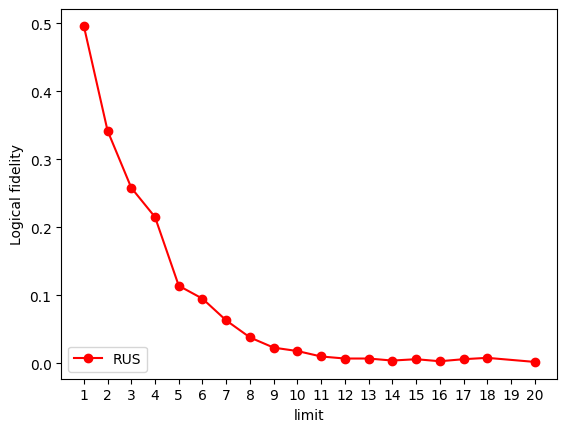

In [21]:
import matplotlib.pyplot as plt

plt.figure()

# Plot limit vs. Fidelity (Count of 0%)
plt.errorbar(
    rus_limit_values,
    logical_fidelity_values,
    label="RUS",
    marker="o",
    alpha=1.0,
    color="red",
)

plt.ylabel("Logical fidelity")
plt.xlabel("limit")
plt.xticks(range(1, 21))
plt.legend(loc="lower left")
plt.show()